In [1]:
from pathlib import Path

data_dir = Path.cwd() / "data"
assert data_dir.exists(), f"Data directory does not exist: {data_dir}"

In [2]:
from enum import Enum

import numpy as np
import h5py

import torch
import torchmetrics
from lightning.pytorch import LightningDataModule, LightningModule, Trainer

from matplotlib import pyplot as plt
import seaborn as sns

# Seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

torch.set_float32_matmul_precision("medium")

In [3]:
CHANNEL_NAMES = ["time_s",
                 "K1_Ch1_Mod2/AI0",  # Rondenschnitt direkt
                 "K1_Ch2_Mod2/AI1",  # Tiefziehen direkt
                 "K1_Ch3_Mod2/AI2",  # Abstrecken direkt
                 "K2_Ch1_Mod2/AI3",  # Tiefziehen oben indirekt
                 "K2_Ch2_Mod2/AI4",  # Tiefziehen unten direkt
                 "K2_Ch3_Mod2/AI5",  # nicht angeschlossen
                 "K3_Ch1_Mod2/AI6",  # Abstrecken oben indrekt
                 "K3_Ch2_Mod2/AI7",  # Abstrecken Stempehalter indirekt
                 "K3_Ch3_Mod2/AI8",  # Abstrecken unten indirekt
                 "Mod2/AI9",         # in Klärung
                 "Mod7 A0",          # Thermospannung 1
                 "Mod7 A1",          # Thermospannung 2
                 "Mod7 A2",          # in Klärung
                 "Mod7 A3",          # in Klärung
                 ]


class SignalPortion(Enum):
    DIRECT = [1, 2, 3, 5]
    INDIRECT = [4, 7, 8, 9]
    ALL = list(range(1, len(CHANNEL_NAMES)))


class SheetMetalDataset(torch.utils.data.Dataset):
    """Dataset for sheet metal forming measurements."""

    def __init__(self, data: np.ndarray, metadata: dict):
        """
        Args:
            data: Array of shape (n_entries, n_signals, n_points)
            metadata: Dict with V, T, A arrays
        """
        self.data = torch.from_numpy(data).float()
        self.V = torch.from_numpy(metadata["V"]).long()
        self.T = torch.from_numpy(metadata["T"]).long()
        self.A = torch.from_numpy(metadata["A"]).long()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            "data": self.data[idx],
            "V": self.V[idx],
            "T": self.T[idx],
            "A": self.A[idx],
        }


class SheetMetalDataModule(LightningDataModule):
    """LightningDataModule for sheet metal forming data."""

    def __init__(
        self,
        data_path: Path,
        signal_portion: SignalPortion,
        batch_size: int = 32,
        num_workers: int = 4,
        train_ratio: float = 0.7,
        val_ratio: float = 0.15,
        seed: int = 42,
    ):
        super().__init__()
        self.data_path = data_path
        self.signal_portion = signal_portion
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.seed = seed

        self.save_hyperparameters(ignore=["data_path"])

    def setup(self, stage: str = None):
        # Load data from HDF5
        with h5py.File(self.data_path, "r") as h5f:
            signal_indices = self.signal_portion.value
            data = h5f["data"][:, signal_indices, :]
            all_signal_keys = [k for k in h5f["data"].attrs["signal_keys"]]
            self.signal_keys = [all_signal_keys[i] for i in signal_indices]
            metadata = {
                "V": h5f["meta_data/V"][:],
                "T": h5f["meta_data/T"][:],
                "A": h5f["meta_data/A"][:],
            }

        # Reproducible shuffle and split
        rng = np.random.default_rng(self.seed)
        indices = rng.permutation(len(data))

        n_train = int(len(data) * self.train_ratio)
        n_val = int(len(data) * self.val_ratio)

        def make_dataset(idx):
            return SheetMetalDataset(data[idx], {k: v[idx] for k, v in metadata.items()})

        self.train_dataset = make_dataset(indices[:n_train])
        self.val_dataset = make_dataset(indices[n_train:n_train + n_val])
        self.test_dataset = make_dataset(indices[n_train + n_val:])

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )


data_module = SheetMetalDataModule(
    data_path=data_dir / "all_data.hdf5",
    signal_portion=SignalPortion.INDIRECT,
)
data_module.setup()

In [4]:
# Test the data module
print(f"Signal keys: {data_module.signal_keys}")
print(f"Train samples: {len(data_module.train_dataset)}")
print(f"Val samples: {len(data_module.val_dataset)}")
print(f"Test samples: {len(data_module.test_dataset)}")

# Check a batch
batch = next(iter(data_module.train_dataloader()))
print(f"\nBatch data shape: {batch['data'].shape}")
print(f"Batch V: {batch['V']}")
print(f"Batch T: {batch['T']}")
print(f"Batch A: {batch['A']}")

Signal keys: ['K2_Ch1_Mod2__AI3', 'K3_Ch1_Mod2__AI6', 'K3_Ch2_Mod2__AI7', 'K3_Ch3_Mod2__AI8']
Train samples: 3500
Val samples: 750
Test samples: 750

Batch data shape: torch.Size([32, 4, 1200])
Batch V: tensor([6, 8, 9, 5, 4, 5, 2, 0, 6, 7, 1, 5, 6, 4, 8, 7, 9, 2, 6, 3, 1, 3, 3, 7,
        5, 4, 5, 2, 2, 2, 5, 8])
Batch T: tensor([2, 3, 3, 2, 2, 2, 1, 0, 2, 3, 1, 2, 2, 2, 3, 3, 3, 1, 2, 1, 1, 1, 1, 3,
        2, 2, 2, 1, 1, 1, 2, 3])
Batch A: tensor([3, 2, 3, 2, 1, 2, 2, 0, 3, 1, 1, 2, 3, 1, 2, 1, 3, 2, 3, 3, 1, 3, 3, 1,
        2, 1, 2, 2, 2, 2, 2, 2])


Sample data shape: torch.Size([4, 1200])
Sample V: 8
Sample T: 3
Sample A: 2


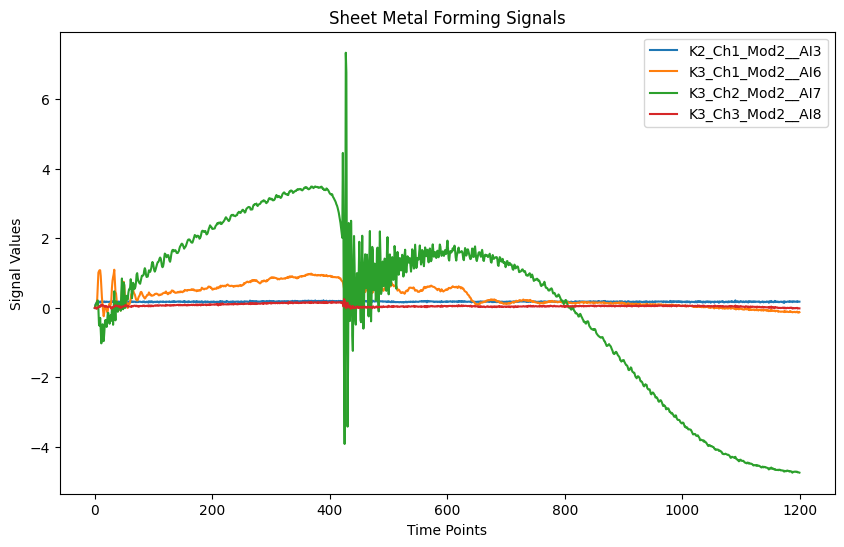

In [5]:
# Show one instance
sample = data_module.train_dataset[0]
print("Sample data shape:", sample["data"].shape)
print("Sample V:", sample["V"].item())
print("Sample T:", sample["T"].item())
print("Sample A:", sample["A"].item())
plt.figure(figsize=(10, 6))
for i, signal in enumerate(data_module.signal_keys):
    plt.plot(sample["data"][i].numpy(), label=signal)
plt.title("Sheet Metal Forming Signals")
plt.xlabel("Time Points")
plt.ylabel("Signal Values")
plt.legend()
plt.show()

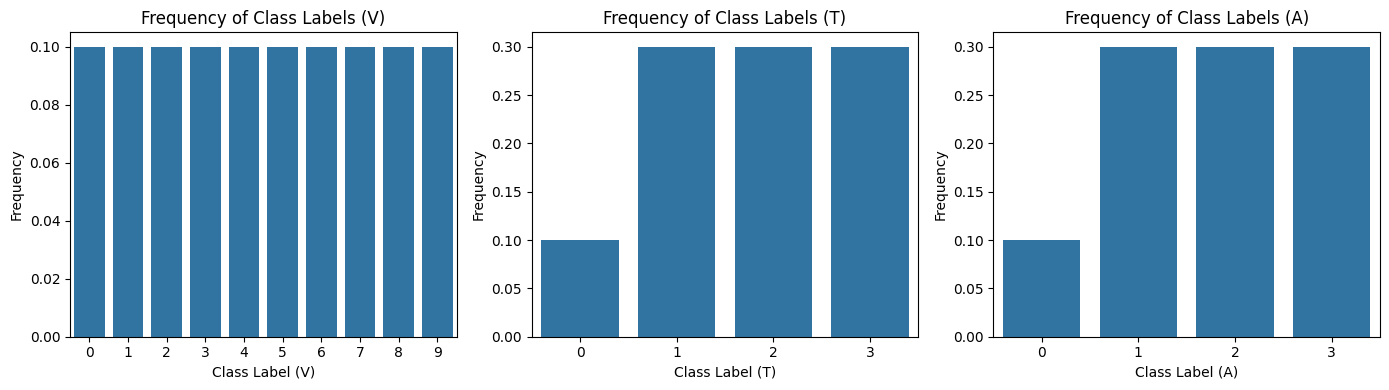

In [6]:
# Plot class label frequencies for V, T, A
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, label in zip(axes, ["V", "T", "A"]):
    all_labels = torch.cat([
        getattr(data_module.train_dataset, label),
        getattr(data_module.val_dataset, label),
        getattr(data_module.test_dataset, label),
    ])
    unique, counts = torch.unique(all_labels, return_counts=True)
    freq = counts.float() / counts.sum().float()
    sns.barplot(x=unique.numpy(), y=freq.numpy(), ax=ax)
    ax.set_title(f"Frequency of Class Labels ({label})")
    ax.set_xlabel(f"Class Label ({label})")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [7]:
# Train a simple 1d-CNN to predict V, T, A from signals

def conv_block(in_ch, out_ch, kernel_size, pool_size=2, dropout=0.1):
    return torch.nn.Sequential(
        torch.nn.Conv1d(in_ch, out_ch, kernel_size, padding=kernel_size // 2),
        torch.nn.BatchNorm1d(out_ch),
        torch.nn.ReLU(),
        torch.nn.MaxPool1d(pool_size),
        torch.nn.Dropout(dropout),
    )


class SimpleCNN(LightningModule):
    def __init__(self, n_signals: int, n_classes: dict, lr: float = 1e-3, dropout: float = 0.25):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.n_classes = n_classes

        # 1200 -> 600 -> 150 -> 37 -> 9 -> 1
        self.backbone = torch.nn.Sequential(
            conv_block(n_signals, 32, kernel_size=7,
                       pool_size=2, dropout=dropout * 0.5),
            conv_block(32, 64, kernel_size=5, pool_size=4,
                       dropout=dropout * 0.5),
            conv_block(64, 128, kernel_size=5, pool_size=4, dropout=dropout),
            conv_block(128, 256, kernel_size=3, pool_size=4, dropout=dropout),
            torch.nn.AdaptiveAvgPool1d(1),
            torch.nn.Flatten(),
            torch.nn.Dropout(dropout),
        )

        self.head_V = torch.nn.Linear(256, n_classes["V"])
        self.head_T = torch.nn.Linear(256, n_classes["T"])
        self.head_A = torch.nn.Linear(256, n_classes["A"])

        self.criterion = torch.nn.CrossEntropyLoss()

        # Metrics for each stage and label
        for stage in ["train", "val", "test"]:
            for label, num_classes in n_classes.items():
                setattr(self, f"{stage}_acc_{label}",
                        torchmetrics.Accuracy(task="multiclass", num_classes=num_classes))
                setattr(self, f"{stage}_f1_{label}",
                        torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average="macro"))

    def forward(self, x):
        features = self.backbone(x)
        return self.head_V(features), self.head_T(features), self.head_A(features)

    def _step(self, batch, stage: str):
        data, V, T, A = batch["data"], batch["V"], batch["T"], batch["A"]
        V_out, T_out, A_out = self(data)

        loss = (self.criterion(V_out, V) +
                self.criterion(T_out, T) +
                self.criterion(A_out, A))

        # Update and log metrics
        preds = {"V": V_out, "T": T_out, "A": A_out}
        targets = {"V": V, "T": T, "A": A}

        for label in ["V", "T", "A"]:
            acc = getattr(self, f"{stage}_acc_{label}")
            f1 = getattr(self, f"{stage}_f1_{label}")
            acc(preds[label], targets[label])
            f1(preds[label], targets[label])
            self.log(f"{stage}_acc_{label}", acc, prog_bar=(stage != "train"))
            self.log(f"{stage}_f1_{label}", f1, prog_bar=(stage != "train"))

        self.log(f"{stage}_loss", loss, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self._step(batch, "test")

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)


# Check label ranges
train_V, train_T, train_A = data_module.train_dataset.V, data_module.train_dataset.T, data_module.train_dataset.A
print(f"V: {train_V.min().item()}-{train_V.max().item()}, T: {train_T.min().item()}-{train_T.max().item()}, A: {train_A.min().item()}-{train_A.max().item()}")

n_classes = {"V": train_V.max().item() + 1, "T": train_T.max().item() +
             1, "A": train_A.max().item() + 1}
print(f"n_classes: {n_classes}")

model = SimpleCNN(n_signals=len(data_module.signal_keys), n_classes=n_classes)

V: 0-9, T: 0-3, A: 0-3
n_classes: {'V': 10, 'T': 4, 'A': 4}


In [8]:
# Show data shapes through the model
from torchinfo import summary

# Get input shape from data
sample_batch = next(iter(data_module.train_dataloader()))
input_shape = sample_batch["data"].shape  # (batch, n_signals, n_points)

summary(model, input_size=input_shape, col_names=[
        "input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SimpleCNN                                [32, 4, 1200]             [32, 10]                  --
├─Sequential: 1-1                        [32, 4, 1200]             [32, 256]                 --
│    └─Sequential: 2-1                   [32, 4, 1200]             [32, 32, 600]             --
│    │    └─Conv1d: 3-1                  [32, 4, 1200]             [32, 32, 1200]            928
│    │    └─BatchNorm1d: 3-2             [32, 32, 1200]            [32, 32, 1200]            64
│    │    └─ReLU: 3-3                    [32, 32, 1200]            [32, 32, 1200]            --
│    │    └─MaxPool1d: 3-4               [32, 32, 1200]            [32, 32, 600]             --
│    │    └─Dropout: 3-5                 [32, 32, 600]             [32, 32, 600]             --
│    └─Sequential: 2-2                   [32, 32, 600]             [32, 64, 150]             --
│    │    └─Conv1d: 3-6           

In [9]:
trainer = Trainer(max_epochs=10, accelerator="auto",
                  devices="auto", precision="bf16-mixed")
trainer.fit(model, datamodule=data_module)

Using bfloat16 Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.13/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242

┏━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name        ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ backbone    │ Sequential         │  151 K │ train │     0 │
│ 1  │ head_V      │ Linear             │  2.6 K │ train │     0 │
│ 2  │ head_T      │ Linear             │  1.0 K │ train │     0 │
│ 3  │ head_A      │ Linear             │  1.0 K │ train │     0 │
│ 4  │ criterion   │ CrossEntropyLoss   │      0 │ train │     0 │
│ 5  │ train_acc_V │ MulticlassAccuracy │      0 │ train │     0 │
│ 6  │ train_f1_V  │ MulticlassF1Score  │      0 │ train │     0 │
│ 7  │ train_acc_T │ MulticlassAccuracy │      0 │ train │     0 │
│ 8  │ train_f1_T  │ MulticlassF1Score  │      0 │ train │     0 │
│ 9  │ train_acc_A │ MulticlassAccuracy │      0 │ train │     0 │
│ 10 │ train_f1_A  │ MulticlassF1Score  │      0 │ train │     0 │
│ 11 │ val_acc_V   │ MulticlassAccuracy │      0 │ train │     0 │
│ 12 │ val_f1_V    │ MulticlassF1Score  │      0 │ train │     0 │
│ 13 │ val_acc_T   │ MulticlassAccuracy │      0 │ train │     0 │
│ 14 │ val_f1_T    │ MulticlassF1Score  │      0 │ train │     0 │
│ 15 │ val_acc_A   │ MulticlassAccuracy │      0 │ train │     0 │
│ 16 │ val_f1_A    │ MulticlassF1Score  │      0 │ train │     0 │
│ 17 │ test_acc_V  │ MulticlassAccuracy │      0 │ train │     0 │
│ 18 │ test_f1_V   │ MulticlassF1Score  │      0 │ train │     0 │
│ 19 │ test_acc_T  │ MulticlassAccuracy │      0 │ train │     0 │
│ 20 │ test_f1_T   │ MulticlassF1Score  │      0 │ train │     0 │
│ 21 │ test_acc_A  │ MulticlassAccuracy │      0 │ train │     0 │
│ 22 │ test_f1_A   │ MulticlassF1Score  │      0 │ train │     0 │
└────┴─────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 156 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 156 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 50                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


In [10]:
test_results = trainer.test(model, datamodule=data_module)
print("Test results:", test_results)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_acc_A         │    0.9666666388511658     │
│        test_acc_T         │    0.9853333234786987     │
│        test_acc_V         │    0.9586666822433472     │
│         test_f1_A         │    0.9723796844482422     │
│         test_f1_T         │    0.9878289699554443     │
│         test_f1_V         │    0.9588801264762878     │
│         test_loss         │    0.27726927399635315    │
└───────────────────────────┴───────────────────────────┘

Test results: [{'test_acc_V': 0.9586666822433472, 'test_f1_V': 0.9588801264762878, 'test_acc_T': 0.9853333234786987, 'test_f1_T': 0.9878289699554443, 'test_acc_A': 0.9666666388511658, 'test_f1_A': 0.9723796844482422, 'test_loss': 0.27726927399635315}]


In [11]:
# Attribution analysis using Captum Integrated Gradients
from captum.attr import IntegratedGradients

# Put model in eval mode
model.eval()
model.to("cpu")

# Create wrapper functions for each head (Captum needs single output)
def forward_V(x):
    return model(x)[0]

def forward_T(x):
    return model(x)[1]

def forward_A(x):
    return model(x)[2]

# Get some test samples
n_samples = 16
test_loader = data_module.test_dataloader()
test_batch = next(iter(test_loader))
inputs = test_batch["data"][:n_samples].cpu()
targets = {
    "V": test_batch["V"][:n_samples],
    "T": test_batch["T"][:n_samples],
    "A": test_batch["A"][:n_samples],
}

# Baseline is zeros (no signal)
baseline = torch.zeros_like(inputs)

# Compute attributions for each head
ig_V = IntegratedGradients(forward_V)
ig_T = IntegratedGradients(forward_T)
ig_A = IntegratedGradients(forward_A)

print("Computing attributions...")
attr_V = ig_V.attribute(inputs, baselines=baseline, target=targets["V"], n_steps=50)
attr_T = ig_T.attribute(inputs, baselines=baseline, target=targets["T"], n_steps=50)
attr_A = ig_A.attribute(inputs, baselines=baseline, target=targets["A"], n_steps=50)

# Average attributions across samples: (n_samples, n_signals, n_points) -> (n_signals, n_points)
avg_attr_V = attr_V.abs().mean(dim=0).detach().numpy()
avg_attr_T = attr_T.abs().mean(dim=0).detach().numpy()
avg_attr_A = attr_A.abs().mean(dim=0).detach().numpy()

print(f"Attribution shape: {avg_attr_V.shape}")

Computing attributions...
Attribution shape: (4, 1200)


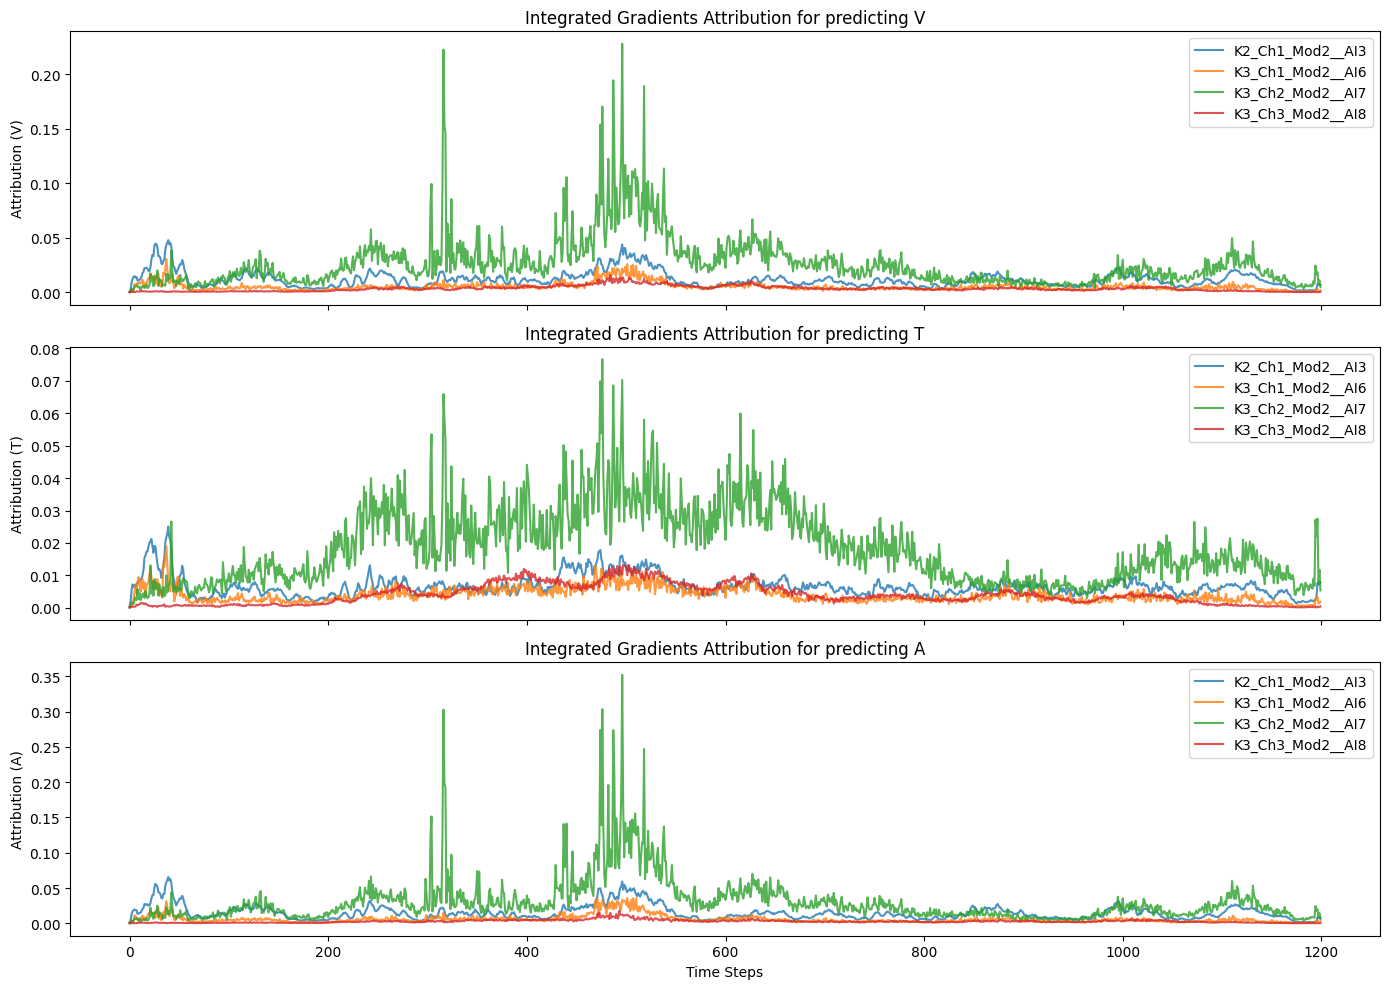

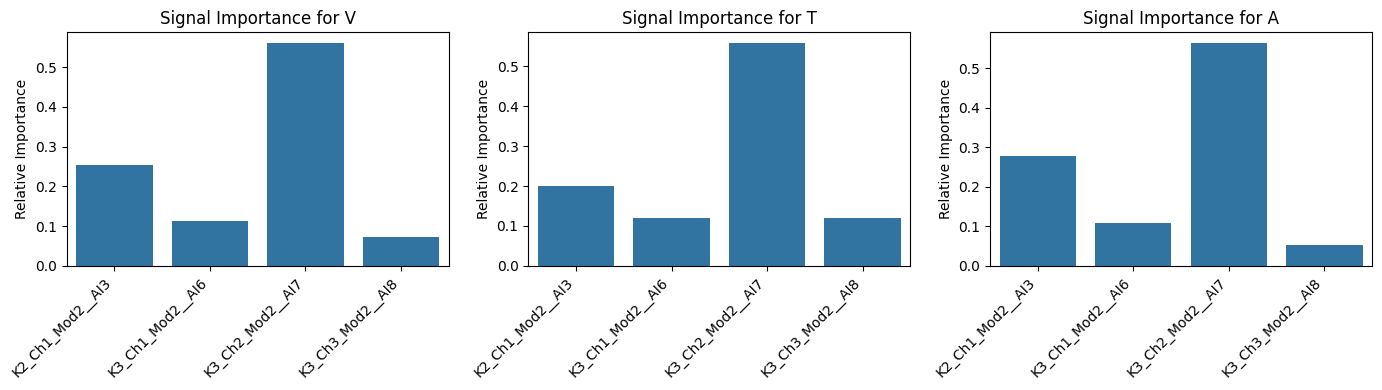

In [12]:
# Visualize attributions
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for ax, attr, label in zip(axes, [avg_attr_V, avg_attr_T, avg_attr_A], ["V", "T", "A"]):
    for i, signal_name in enumerate(data_module.signal_keys):
        ax.plot(attr[i], label=signal_name, alpha=0.8)
    ax.set_ylabel(f"Attribution ({label})")
    ax.set_title(f"Integrated Gradients Attribution for predicting {label}")
    ax.legend(loc="upper right")

axes[-1].set_xlabel("Time Steps")
plt.tight_layout()
plt.show()

# Also show aggregated importance per signal
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, attr, label in zip(axes, [avg_attr_V, avg_attr_T, avg_attr_A], ["V", "T", "A"]):
    # Sum attribution over time for each signal
    signal_importance = attr.sum(axis=1)
    signal_importance = signal_importance / signal_importance.sum()  # Normalize
    
    sns.barplot(x=list(range(len(data_module.signal_keys))), y=signal_importance, ax=ax)
    ax.set_xticks(range(len(data_module.signal_keys)))
    ax.set_xticklabels([s.split("/")[-1] for s in data_module.signal_keys], rotation=45, ha="right")
    ax.set_ylabel("Relative Importance")
    ax.set_title(f"Signal Importance for {label}")

plt.tight_layout()
plt.show()